# ___Introduction à la création des traits___

---

Jusque-là, nous avons utilisé des traits provenant de la librairie standard tels Clone, Debug, Add etc... Les crates dont dépendent nos programmes fournissent aussi des traits que nous pouvons implémenter pour nos propres types. Les traits sont similaires aux `interfaces` dans d'autres langages de programmation.

Dans cette partie, nous verrons comment créer nos propres traits et ainsi fournir à nos types des comportements communs.

## La définition d'un trait

> Déclarer un trait se fait par le mot-clé `trait` suivi du nom du trait.  Par convention, tous comme les types, on préférera utiliser le CamelCase, ainsi, il ne sera pas par exemple question ici de trait hex_dump mais de trait HexDump.

> Une fois le trait déclaré, il faudra ouvrir un bloc `{` ... `}` et définir les méthodes du trait.

- Il existe deux types de méthodes, celles qu'il faut **obligatoirement implémenter**, elles sont dites 'required methods' dans la documentation des traits et celles dont on donne une **implémentation par défaut**, elles peuvent être redéfinies si on veut.

In [7]:
{
    trait Foo {                                // Foo trait declaration
        fn bar(&self);                         // Must be implemented
        fn dude(&self) {                       // Default provided
            println!("default dude method");
            self.bar();
        }
        fn g() {}                              // Other default method without self member
    }
    
    impl Foo for usize {
        fn bar(&self) {                        // bar must be defined
            dbg!(self);
        }
    }

    impl Foo for u64 {
        fn bar(&self) {                        // bar must be defined
            dbg!(self);
        }
        fn dude(&self) {                       // Overiding default method
            println!("overided default dude method");
        }
    }
    
    let a: usize = 42;
    a.bar();
    a.dude();
    
    let b: u64 = 21;
    b.bar();
    b.dude();
}

[src/lib.rs:34] self = 42
[src/lib.rs:34] self = 42
[src/lib.rs:40] self = 21


default dude method
overided default dude method


()

*L'implémentation des traits pour nos types se fait exactement de la même façon que les implémentations que nous avons déjà faites des traits de la std.*

## Polymorphisme statique

Dans le chapitre sur les allocations dynamiques, nous avons vu que Box pouvait être utilisé pour faire des traits dynamiques, ainsi une fonction retournait `Box<dyn Trait>` par exemple. Sans trop entrer dans les détails, cette approche est qualifiée de **polymorphisme dynamique** et c'est au runtime que les méthodes du trait sont associées au type (j'ai fourni une explication délibérément simpliste).

Cependant, il existe en Rust une autre approche qui se nomme **polymorphisme statique** et qui est évaluée au moment de la compilation. Plutôt que de retourner un type ou de prendre un type en paramètre, on aurait une expression du genre `qui implemente tel trait`.

In [9]:
{
    fn iterateur_exemple() -> impl Iterator<Item = i32> {
        vec![1, 2, 3].into_iter()
    }
    for elem in iterateur_exemple() {
        dbg!(elem);
    }
}

[src/lib.rs:27] elem = 1
[src/lib.rs:27] elem = 2
[src/lib.rs:27] elem = 3


()

**Il est courant de trouver ce type de polymorphisme pour les traits Iterator, Read et Write.**

*Notez que cela peut faciliter les choses quand on a affaire à des types trop complexes. Ici, le type est en réalité `std::vec::IntoIter<i32>`.*

- Voici certaines autres possibilités de pattern :

In [10]:
{
    trait Foo {                                // Foo trait declaration
        fn bar(&self);                         // Must be implemented
    }

    impl Foo for std::vec::IntoIter<i32> {
        fn bar(&self) {
            dbg!(self);
        }
    }

    fn iterateur_exemple() -> impl Iterator<Item = i32> + Foo {
        let v = vec![1, 2, 3].into_iter();
        v
    }
    let i = iterateur_exemple();
    i.bar();

    fn example2(t: impl Iterator<Item = i32> + Foo) {
    // fn example2<T: Iterator<Item = i32> + Foo>(t: T) {
        t.bar();
        for elem in t {
            dbg!(elem);
        }
    }
    example2(i);
}

[src/lib.rs:29] self = IntoIter(
    [
        1,
        2,
        3,
    ],
)
[src/lib.rs:29] self = IntoIter(
    [
        1,
        2,
        3,
    ],
)
[src/lib.rs:43] elem = 1
[src/lib.rs:43] elem = 2
[src/lib.rs:43] elem = 3


()

## La règle de l'orphelin

Enfin, tout débutant doit savoir qu'il existe en rust une règle nommée **orphan rule** ou règle de l'orphelin en français. Cette règle dit qu'il est **IMPOSSIBLE** d'implémenter un trait défini à l'extérieur de notre crate (std ou dépendances par exemples) pour un type définit lui aussi à l'extérieur de notre crate.

### Démonstration

- Voilà ce qui se passe si je cherche par exemple à implementer le trait Display de la std avec le type Vec<u32> qui vient aussi de la std. 

In [11]:
{
    use std::fmt;

    impl fmt::Display for Vec<i32> {
        fn fmt(&self, f: &mut fmt::Formatter) -> fmt::Result {
            write!(f, "[{}]", self.iter().map(|i| i.to_string()).collect::<Vec<_>>().join(", "))
        }
    }
}

Error: only traits defined in the current crate can be implemented for types defined outside of the crate

*Dites-vous que si une implémentation d'un trait de la std pour un type de la std n'a pas été faite, c'est peut-être pour une bonne raison... Sinon, développez-la et proposez une RFC !*

In [44]:
:dep petgraph = "*"
:dep petgraph-evcxr = "*"

extern crate petgraph;
use petgraph::graph::Graph;
use petgraph::dot::Dot;
use petgraph_evcxr::{draw_graph, draw_dot};

let mut g : Graph<&str, &str> = Graph::new();
let main = g.add_node("main crate\nWTF ?!?");
let a = g.add_node("One crate from crates.io\nimpl Display for Vec<u32> { ... }\nresult is like [0, 1, 2, ...]\nwith comma separator");
let b = g.add_node("Another crate from crates.io\nimpl Display for Vec<u32> { ... }\nresult is like [0: 1: 2: ...]\nwith colon separator");

g.add_edge(a, main, "");
g.add_edge(b, main, "");

draw_graph(&g);

La même règle s'applique si je veux implémenter un trait venant d'une crate extérieure avec un type venant d'une crate aussi. **Si cela était possible, il pourrait y avoir des implémentations conflictuelles !**

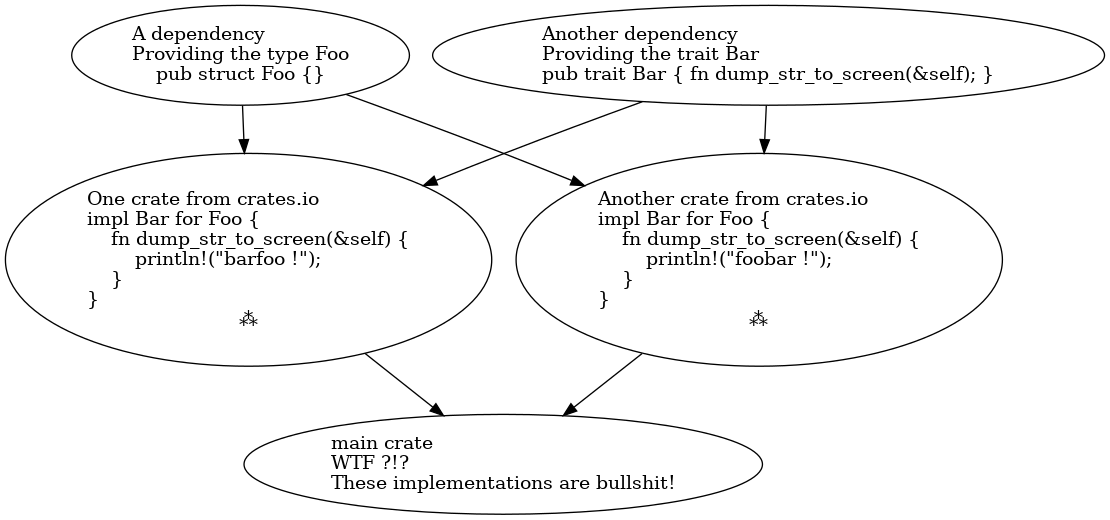

In [46]:
:dep petgraph = "*"
:dep petgraph-evcxr = "*"

extern crate petgraph;
use petgraph::graph::Graph;
use petgraph::dot::Dot;
use petgraph_evcxr::{draw_graph, draw_dot};

let mut g : Graph<&str, &str> = Graph::new();
let main = g.add_node("main crate\nWTF ?!?\nThese implementations are bullshit!");
let a = g.add_node("One crate from crates.io\nimpl Bar for Foo {\n    fn dump_str_to_screen(&self) {\n        println!(\"barfoo !\");\n    }\n}\n⁂");
let b = g.add_node("Another crate from crates.io\nimpl Bar for Foo {\n    fn dump_str_to_screen(&self) {\n        println!(\"foobar !\");\n    }\n}\n⁂");
let c = g.add_node("A dependency\nProviding the type Foo\npub struct Foo {}");
let d = g.add_node("Another dependency\nProviding the trait Bar\npub trait Bar { fn dump_str_to_screen(&self); }");
g.add_edge(a, main, "");
g.add_edge(b, main, "");
g.add_edge(c, a, "");
g.add_edge(d, a, "");
g.add_edge(c, b, "");
g.add_edge(d, b, "");

draw_graph(&g);

### Contournement

Pour contourner cette règle, on utilise généralement la technique du newtype, c'est-à-dire d'englober le type extérieur dans un type structure tuple de notre crate.

In [12]:
{
    struct MyVector(Vec<i32>);

    use std::fmt;

    impl fmt::Display for MyVector {
        fn fmt(&self, f: &mut fmt::Formatter) -> fmt::Result {
            write!(f, "[{}]", self.0.iter().map(|i| i.to_string()).collect::<Vec<_>>().join(", "))
        }
    }
    println!("{}", MyVector(vec!(0, 1, 2)));
}

[0, 1, 2]


()